<a href="https://colab.research.google.com/github/alessandronicolini/IncrementalLearning/blob/main/LearningWithoutForgetting2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [73]:
# upload work files from your git hub repository
import sys

!git clone https://github.com/alessandronicolini/IncrementalLearning.git # clone proj repository
!rm -rf IncrementalLearning/README.md 
!rm -rf IncrementalLearning/baselines.ipynb

path = 'IncrementalLearning/'
if path not in sys.path:
    sys.path.append('IncrementalLearning/')

!pip3 install import_ipynb

fatal: destination path 'IncrementalLearning' already exists and is not an empty directory.


In [74]:
import torch
import os
import torch.nn as nn
from torch.utils.data import Subset, DataLoader
import torch.optim as optim
from torchvision import transforms
import numpy as np
import import_ipynb
import copy
import pickle
import pandas as pd
# project classes --------------------------------------------------------------
from IncrementalLearning.cifar100 import ilCIFAR100
from resnet_cifar import resnet32

In [68]:
class lwf(nn.Module):
  def __init__(self, random_seed, batch_size):
    super(lwf, self).__init__()
    
    self.batch_size = batch_size
    self.classes_per_task = 10
    self.num_tasks = 10
    self.LR = 2
    self.MOMENTUM = 0.9
    self.WEIGHT_DECAY = 1e-5
    self.MILESTONES = [49,63]
    self.GAMMA = 0.2
    self.numepochs = 2
    self.random_seed = random_seed

    self.original_training_set = ilCIFAR100(self.classes_per_task, random_seed)
    self.original_test_set = ilCIFAR100(self.classes_per_task, random_seed, train=False)
    
    self.model = resnet32(num_classes=100).to('cuda')
    self.criterion = nn.BCEWithLogitsLoss()
    self.optimizer = optim.SGD(self.model.parameters(), lr=self.LR, momentum=self.MOMENTUM, weight_decay=self.WEIGHT_DECAY)
    self.scheduler = optim.lr_scheduler.MultiStepLR(self.optimizer, milestones=self.MILESTONES, gamma=self.GAMMA)
    
    self.diz = self.original_training_set.get_dict()
    self.task_counter = -1

  def forward(self, x):
    self.model = self.model.cuda()
    return self.model.forward(x)

  def update_parameters(self, train_dataloader):

    self.task_counter += 1 # new incoming task is starting
    old_model = copy.deepcopy(self)
    old_model.eval()
    old_model.to('cuda')

    for epoch in range(self.numepochs):
      for inputs,labels in train_dataloader:
        labels = torch.tensor([torch.tensor(self.diz[c.item()]) for c in labels])
        inputs=inputs.to('cuda')
        labels=labels.to('cuda')
        self.optimizer.zero_grad()
        outputs=self.model(inputs)

        new_target=torch.eye(100)[labels] 
        new_target=new_target.to('cuda')

        if self.task_counter == 0:
          loss=self.criterion(outputs,new_target)
        else:
          seen_classes = self.task_counter*self.classes_per_task
          #current_classes = seen_classes + self.classes_per_task

          old_target=old_model(inputs)
          old_target=torch.sigmoid(old_target).cuda()
          target = torch.cat((old_target[:,:seen_classes], new_target[:, seen_classes:]), dim=1)
          loss=self.criterion(outputs,target)

        loss.backward()
        self.optimizer.step()
      self.scheduler.step()

        
  # deep copy the model
  def train_model(self):
    
    train_indices = self.original_training_set.get_batch_indexes()
    test_indices = self.original_test_set.get_batch_indexes()
    current_test_indexes=[]
  
    accuracy = 0 
    test_acc = []

    for i in range(self.num_tasks):
      train_dataset = Subset(self.original_training_set,train_indices[i])
      current_test_indexes += test_indices[i].tolist()
      test_dataset = Subset(self.original_test_set,current_test_indexes)
      train_dataloader = DataLoader(train_dataset, batch_size=self.batch_size, shuffle=False)# shuffle=True)
      test_dataloader = DataLoader(test_dataset, batch_size=self.batch_size, shuffle=False)#shuffle=True)        
      self.train()
      self.update_parameters(train_dataloader)
      self.train(False) # Set Network to evaluation mode
      running_corrects = 0
      for inputs, labels in test_dataloader:
          labels = torch.tensor([torch.tensor(self.diz[c.item()]) for c in labels])
          inputs = inputs.to('cuda')
          labels = labels.to('cuda')
          outputs = self.model(inputs)
          _, preds = torch.max(outputs.data, 1)
          running_corrects += torch.sum(preds == labels.data).data.item()
      accuracy = running_corrects / float(len(test_dataloader.dataset))
      print('task %d\tTest Accuracy: %.2f' % (i, 100.0 * accuracy))
      print('-' * 80)
      test_acc.append(accuracy)

    with open("1Lwf_"+str(self.random_seed), "wb") as file:
      pickle.dump(test_acc, file, pickle.HIGHEST_PROTOCOL)
    

In [ ]:
SEED = [666, 404, 182]
for i in range(3):
  print("NEW RUN, seed %d"%(SEED[i]))
  model = lwf(batch_size = 128, random_seed = SEED[i])
  model.train_model()

[0.356, 0.17, 0.163, 0.12025, 0.0982, 0.09716666666666667, 0.07985714285714286, 0.0815, 0.07055555555555555, 0.0645, 0.441, 0.1915, 0.129, 0.0985, 0.093, 0.07783333333333334, 0.07271428571428572, 0.06225, 0.05677777777777778, 0.0516, 0.262, 0.095, 0.12, 0.0965, 0.0828, 0.06133333333333333, 0.059571428571428574, 0.056875, 0.05, 0.0453]


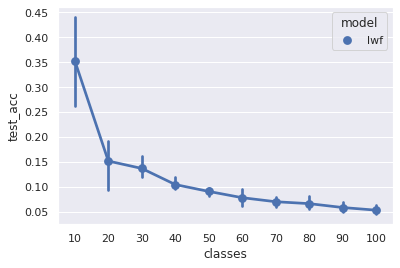

In [72]:
import seaborn as sns
import matplotlib.pyplot as plt

test_acc = []
for seed in SEED:
  with open('1Lwf_'+str(seed), 'rb') as f:
    current = pickle.load(f)
    test_acc += current

acc_dict = {'model': ['lwf' for i in range(30)], 
            'classes': [i for i in range(10,110,10)]*3,
            'test_acc': test_acc}
            
acc_df = pd.DataFrame(data=acc_dict)

sns.set_theme(style="darkgrid")
ax = sns.pointplot(x="classes", y="test_acc", hue="model", data=acc_df)